In [1]:
import cv2
import os
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, BatchNormalization,Bidirectional
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model



2024-06-23 18:12:57.183013: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 18:12:57.184329: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 18:12:57.241210: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 18:12:57.451598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 18:12:58.160417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
originals = './test_data/originals'
deepfakes = './test_data/deepfakes'

In [3]:
BaseOptions = mp.tasks.BaseOptions
FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a face detector instance with the video mode:
detector_options = FaceDetectorOptions(
    base_options=BaseOptions(model_asset_path='./models/detector.tflite'),
    running_mode=VisionRunningMode.VIDEO)

In [4]:
def edge_detection(vid_path, fps, t_lower, t_upper, encoding_dim=1000, epochs=5, batch_size=256):
    video = cv2.VideoCapture(vid_path)
    original_fps = video.get(cv2.CAP_PROP_FPS)

    if fps > original_fps:
        interval = 1
    else:
        interval = int(original_fps / fps)

    frame_count = 0

    edge_diffs = []
    timestamps = []

    previous_frame = None

    with vision.FaceDetector.create_from_options(detector_options) as detector:
        while video.isOpened():
            ret, frame = video.read()

            if not ret:
                break

            if frame_count % interval == 0:
                # timestamp
                frame_timestamp = int(video.get(cv2.CAP_PROP_POS_MSEC))
                # frame
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mp_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
                # detect
                detect = detector.detect_for_video(mp_frame, frame_timestamp)

                if detect.detections:
                    for detection in detect.detections:
                        bbox = detection.bounding_box
                        start_x = int(bbox.origin_x)
                        start_y = int(bbox.origin_y)
                        end_x = int(bbox.origin_x + ((bbox.width*0.1) + bbox.width))
                        end_y = int(bbox.origin_y + ((bbox.height*0.1)+bbox.height))
                        
                        # Crop the face region
                        current_frame = frame[start_y:end_y, start_x:end_x]

                        if previous_frame is not None:
                            current_frame_resized = cv2.resize(current_frame, (previous_frame.shape[1], previous_frame.shape[0]))
                            # Compare edges across consecutive frames
                            edges_prev = cv2.Canny(previous_frame, t_lower, t_upper)
                            edges_curr = cv2.Canny(current_frame_resized, t_lower, t_upper)
                            diff = cv2.absdiff(edges_prev, edges_curr)

                            # Flatten the frame and normalize
                            diff_flat = diff.flatten() / 255.0

                            # Store the flattened edge difference
                            edge_diffs.append(diff_flat)
                            timestamps.append(frame_timestamp)

                        previous_frame = current_frame

                if len(edge_diffs) > 14: # get the first 15 frames only
                    break
            # Add a delay and exit mechanism
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            frame_count += 1

        video.release()
        cv2.destroyAllWindows()

    if edge_diffs:
        max_length = max(len(diff) for diff in edge_diffs)
        edge_diffs = [np.pad(diff, (0, max_length - len(diff)), 'constant') for diff in edge_diffs]
        edge_diffs = np.array(edge_diffs)

        
        timestamps = np.array(timestamps).reshape(-1, 1)
        combined = np.hstack((edge_diffs, timestamps))
        
        return edge_diffs, timestamps, combined
    else:
        return np.array([])  # Return an empty array if no edge differences were computed

In [ ]:
edge_diffs, timestamps, combined = edge_detection(vid_path='./test_data/originals/999.mp4', fps=15, t_lower=50, t_upper=150)

In [7]:
print(edge_diffs.shape)

(15, 25921)


In [5]:
def load_data(originals, deepfakes, fps, t_lower, t_upper):
    X_edge_differences = [] 
    timestamps_list = []
    y = []

    for video_path in os.listdir(originals):
        relative_path = os.path.join(originals, video_path)
        edge_diffs, timestamps, combined = edge_detection(vid_path=relative_path, fps=fps, t_lower=t_lower, t_upper=t_upper)
        if edge_diffs.size == 0:
            continue 
        print(f"Original video {video_path} edge_diffs shape: {edge_diffs.shape}")
        X_edge_differences.append(edge_diffs)
        timestamps_list.append(timestamps)
        y.append(0)
    
    print("ORIGINALS DONEEEEE")

    for video_path in os.listdir(deepfakes):
        relative_path = os.path.join(deepfakes, video_path)
        
        edge_diffs, timestamps, combined = edge_detection(vid_path=relative_path, fps=fps, t_lower=t_lower, t_upper=t_upper)
        if edge_diffs.size == 0:
            continue 
        print(f"Deepfake video {video_path} result shape: {edge_diffs.shape}")
        X_edge_differences.append(edge_diffs)
        timestamps_list.append(timestamps)
        y.append(1)

    # Find the maximum length of the second dimension
    max_length = max(edge_diffs.shape[1] for edge_diffs in X_edge_differences)
    print(f"Max length of second dimension: {max_length}")

    # Pad each element to ensure they all have the same shape
    X_edge_differences_padded = []
    for edge_diffs in X_edge_differences:
        pad_width = max_length - edge_diffs.shape[1]
        padded_result = np.pad(edge_diffs, ((0, 0), (0, pad_width)), mode='constant')
        print(f"Padded result shape: {padded_result.shape}")
        X_edge_differences_padded.append(padded_result)


    return np.array(X_edge_differences_padded), np.array(timestamps_list), np.array(y)

In [ ]:
X_edge_differences, X_timestamps, y = load_data(originals='./test_data/originals', deepfakes='./test_data/deepfakes', fps=15, t_lower=50, t_upper=150)

In [7]:
print(X_edge_differences.shape, X_timestamps.shape, y.shape)

(34, 15, 318096) (34, 15, 1) (34,)


In [8]:
def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    encoder = Model(inputs=input_layer, outputs=encoded)
    return autoencoder, encoder


In [9]:
def train_autoencoder(X, encoding_dim=1000, epochs=10, batch_size=32):
    input_dim = X.shape[2]  # 10000 features
    autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)
    X_flat = X.reshape(-1, input_dim)  # Flatten the data for training
    autoencoder.fit(X_flat, X_flat, epochs=epochs, batch_size=batch_size, shuffle=True)
    return encoder


In [10]:
def compress_data_with_encoder(X, encoder):
    input_dim = X.shape[2]
    X_flat = X.reshape(-1, input_dim)  # Flatten the data for encoding
    X_compressed_flat = encoder.predict(X_flat)
    X_compressed = X_compressed_flat.reshape(X.shape[0], X.shape[1], -1)  # Reshape back to original structure
    return X_compressed


In [11]:
# Train the autoencoder
encoding_dim = 100
epochs = 10
batch_size = 32
encoder = train_autoencoder(X_edge_differences, encoding_dim, epochs, batch_size)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 437ms/step - loss: 0.5445
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 438ms/step - loss: 0.1003
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - loss: 0.0716
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - loss: 0.0658
Epoch 5/10


2024-06-23 18:14:08.378894: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 81432576 bytes after encountering the first element of size 81432576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 440ms/step - loss: 0.0580
Epoch 6/10


2024-06-23 18:14:15.513839: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 81432576 bytes after encountering the first element of size 81432576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - loss: 0.0480
Epoch 7/10


2024-06-23 18:14:22.590995: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 81432576 bytes after encountering the first element of size 81432576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - loss: 0.0440
Epoch 8/10


2024-06-23 18:14:29.673530: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 81432576 bytes after encountering the first element of size 81432576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - loss: 0.0397
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - loss: 0.0392
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 426ms/step - loss: 0.0391


In [13]:
# Compress the data
X_compressed = compress_data_with_encoder(X_edge_differences, encoder)
print(f"Shape of X after compression: {X_compressed.shape}")  # Should be (26, 15, 1000)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Shape of X after compression: (34, 15, 100)


In [15]:
print(X_compressed.shape, X_timestamps.shape)

(34, 15, 100) (34, 15, 1)


In [16]:
combined = np.concatenate((X_compressed, X_timestamps), axis=2)

In [25]:
print(X_timestamps[0][0][-1], combined[1][0][-1])

66 66.0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(combined, y, test_size=0.2)

In [27]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (27, 15, 101)
Shape of y_train: (27,)
Shape of X_test: (7, 15, 101)
Shape of y_test: (7,)


In [28]:
# Define the enhanced LSTM model
model2 = Sequential()

# Add LSTM layers with more units and dropout for regularization
model2.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2))

# Add a Batch Normalization layer
model2.add(BatchNormalization())

# Add Dense layers with Dropout
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()

/mnt/storage/thesis/deepfake_manipulation_detection/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 128)        │       117,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,697 (678.50 KB)

 Trainable params: 173,569 (678.00 KB)

 Non-trainable params: 128 (512.00 B)

In [29]:
history = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4286 - loss: 0.8936 - val_accuracy: 0.1667 - val_loss: 0.7256
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4762 - loss: 0.7269 - val_accuracy: 0.6667 - val_loss: 0.7063
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4286 - loss: 0.8418 - val_accuracy: 0.3333 - val_loss: 0.7123
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6190 - loss: 0.6554 - val_accuracy: 0.3333 - val_loss: 0.7106
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5714 - loss: 0.7276 - val_accuracy: 0.3333 - val_loss: 0.6993
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7143 - loss: 0.6702 - val_accuracy: 0.3333 - val_loss: 0.7003
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6667 - loss: 0.6196 - val_accuracy: 0.3333 - val_loss: 0.6863
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6667 - loss: 0.5671 - val_accuracy: 0.3333 - val_loss: 0.6902
Ep

In [30]:
# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4286 - loss: 0.7321
Test Accuracy: 0.4285714328289032


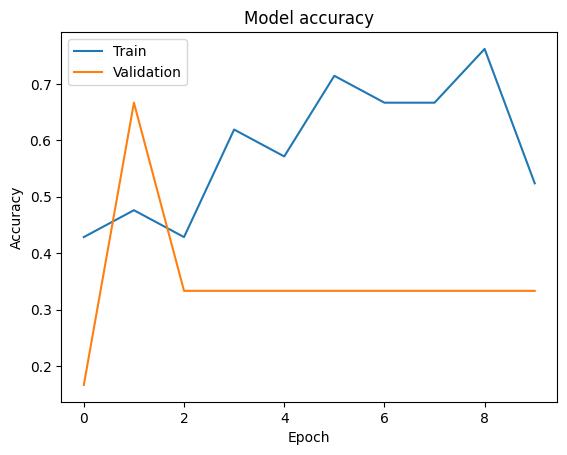

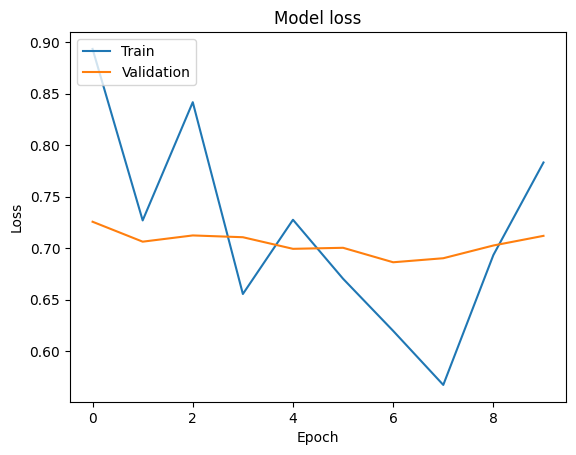

In [31]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()